The goal of this notebook is to align all datasets and clean them.
---
There are going to be four datasets:
1. Yahoo finance stock prices & volumes
1. Yahoo finance stock info (sector, industry)
1. Ycharts operating margin ttm
1. Ycharts derived asset turnover


In [502]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json


First, load new tickers, derived from ycharts asset turnover dataset:

In [503]:
with open("./data/new_aligned_tickers_2128.json") as jsf:
    new_tickers = json.load(jsf)
    new_tickers.remove("HMCTF")
    new_tickers.remove("JANL")
    new_tickers.remove("FRRFF")

In [504]:
len(new_tickers)

2125

# Loading datasets

## Load yf prices an volumes

In [505]:
stocks_yf = (
    pd.read_csv(
        filepath_or_buffer="./data/yf/stocks3m_yf.csv.xz",
        compression="xz",
        header=[0, 1],
        index_col=[
            0,
        ],
        parse_dates=True,
    )
    .sort_index(axis=0)
    .sort_index(axis=1)
)

prices, volume = (
    stocks_yf.loc[:, "adj_close"], # type: ignore
    stocks_yf.loc[:, "volume"], # type: ignore
)

volume: pd.DataFrame = volume.loc[:, new_tickers]
prices: pd.DataFrame = prices.loc[:, new_tickers]

# Since yf volume represents number of shares, convert them to USD
volume = volume * prices

In [506]:
# calculate log-returns
returns = (1 + prices.pct_change()).apply(np.log).iloc[1:]
returns.head(4)

,A,AACAF,AACAY,AAL,AAON,AAP,AAPL,AAT,AATC,AAV.TO,...,SCVL,SCX,SCXLB,SDVKY,SEB,SECVY,SEE,SEGXF,SEIC,SEKEY
Date,,,,,,,,,,,,,,,,,,,,,
2011-04-01,0.586536,0.638088,NaN,0.034250,0.355194,0.157275,0.288566,NaN,-0.174176,0.208848,...,0.385273,0.098881,0.025782,0.378927,0.475129,0.325556,0.210389,0.043658,0.109220,0.301198
2012-04-01,-0.262032,0.124053,0.236969,0.402843,-0.135850,0.157420,0.553773,0.118403,-0.795562,-0.934785,...,0.066868,0.154782,0.248840,-0.287481,-0.125421,-1.209188,-0.405714,-0.460342,-0.109512,-0.552735
2013-04-01,0.096460,0.624154,0.672239,0.208483,0.579970,0.177140,-0.372497,0.272265,0.365460,0.324496,...,0.166484,-0.088756,-0.330763,-0.033939,0.243728,0.060166,0.470759,0.268264,0.386543,0.316270
2014-04-01,0.302534,0.153640,0.160821,0.961769,0.425140,0.510634,0.519973,0.140325,-0.800778,0.546797,...,-0.140848,0.441805,0.594493,0.169797,0.109136,0.710673,0.373093,0.333122,0.155366,1.129708


In [507]:
prices.info()
print()
volume.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14 entries, 2010-04-01 to 2023-04-01
Columns: 2125 entries, A to SEKEY
dtypes: float64(2125)
memory usage: 232.5 KB

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14 entries, 2010-04-01 to 2023-04-01
Columns: 2125 entries, A to SEKEY
dtypes: float64(2125)
memory usage: 232.5 KB


### Delete consecutive NaNs

In [508]:
def remove_consecutive_nan(df: pd.DataFrame, threshold: int) -> pd.DataFrame:
    """Removes columns in a `df` with more than `threshold` consecutive NaN's"""
    m = df.isna()
    b = m.cumsum()
    mask = b.sub(b.mask(m).ffill().fillna(0)).gt(threshold)
    return df.loc[:, ~mask.any(axis=0)]

In [509]:
prices = remove_consecutive_nan(prices, 2)
volume = remove_consecutive_nan(volume, 2)

## Load yf stock info

In [510]:
company_info = pd.read_csv("./data/yf/company_info.csv")

In [511]:
company_info.sector.unique()

array(['Healthcare', 'Technology', 'Industrials', 'Consumer Cyclical',
       'Real Estate', 'Energy', 'Consumer Defensive', 'Basic Materials',
       'Utilities', 'Financial Services', 'Communication Services'],
      dtype=object)

## Load Ycharts Operating Margins

In [512]:
ychopmdf = (
    pd.read_csv(
        "data/ycharts/operating_margin_ttm.csv",
        parse_dates=True,
        index_col=0,
    )
    .sort_index(axis=1)
    .sort_index(axis=0)
    .drop(["2009-04-01", "2010-04-01"])
    .loc[:, new_tickers]
)

In [513]:
ychopmdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2011-04-01 to 2023-04-01
Columns: 2125 entries, A to SEKEY
dtypes: float64(2125)
memory usage: 215.9 KB


## Ycharts Asset Turnover

In [514]:
asset_turnover = (
    pd.read_csv("./data/ycharts/asset_turnover.csv", parse_dates=True, index_col=0)
    .drop(["2009-04-01", "2010-04-01"])
    .sort_index(axis=1)
    .sort_index(axis=0)
    .loc[:, new_tickers]
)

In [515]:
asset_turnover.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2011-04-01 to 2023-04-01
Columns: 2125 entries, A to SEKEY
dtypes: float64(2125)
memory usage: 215.9 KB


# Find common tickers

In [516]:
different_tickers = [
    prices.columns,
    volume.columns,
    company_info.ticker.to_list(),
    ychopmdf.columns,
    asset_turnover.columns,
]

In [517]:
aligned_tickers = sorted(list(set(different_tickers[0]).intersection(*different_tickers)))
len(aligned_tickers)

2125

In [518]:
# import json


# with open(f"./data/new_aligned_tickers_2128.json", "w") as jsf:
#     json.dump(aligned_tickers, jsf)

<Axes: xlabel='Number of misses across two datasets', ylabel='Frequency'>

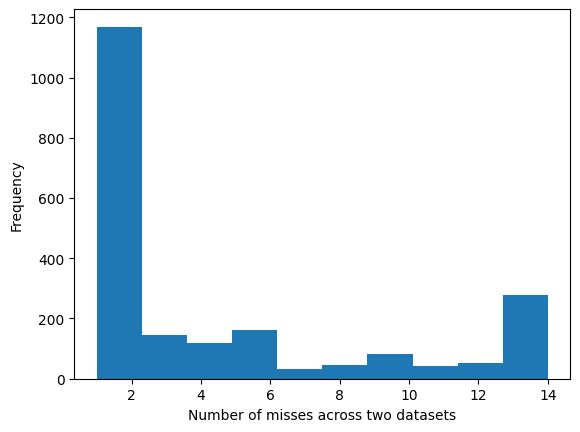

In [519]:
mask_cna = ~(returns.isna() | volume.isna() | ychopmdf.isna() | asset_turnover.isna())
mask_cna = mask_cna & (ychopmdf > 0) & (volume > 1_000_000)
(~mask_cna).sum().plot(kind="hist", xlabel="Number of misses across two datasets")

<Axes: >

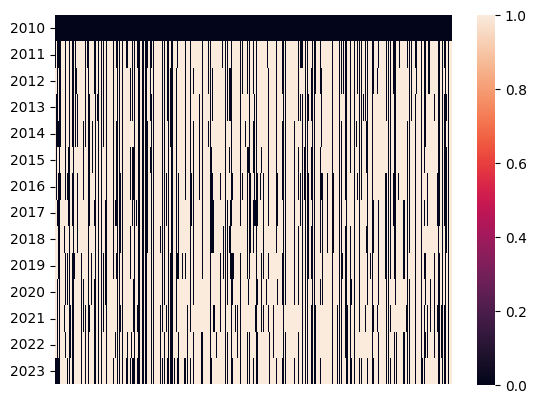

In [520]:
sns.heatmap(mask_cna, xticklabels=False, yticklabels=prices.index.year)  # type: ignore

In [521]:
prices = remove_consecutive_nan(prices.where(mask_cna, other=np.nan).iloc[1:], 2).interpolate(
    method="cubicspline", limit=1
)

volume = remove_consecutive_nan(volume.where(mask_cna, other=np.nan).iloc[1:], 2).interpolate(
    method="cubicspline", limit=1
)

New alignment

<Axes: xlabel='Number of misses across two datasets', ylabel='Frequency'>

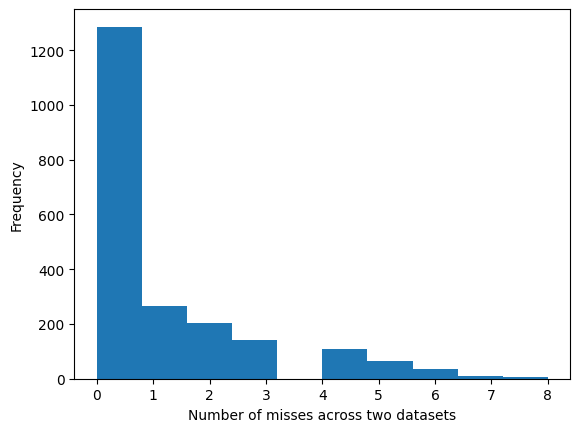

In [522]:
new_mask_cna = ~(returns.isna() | volume.isna() | ychopmdf.isna() | asset_turnover.isna())
new_mask_cna = new_mask_cna & (ychopmdf > 0)
(~new_mask_cna).sum().plot(kind="hist", xlabel="Number of misses across two datasets")

In [523]:
different_tickers = [
    prices.columns,
    volume.columns,
    company_info.ticker.to_list(),
    ychopmdf.columns,
    asset_turnover.columns,
]

aligned_tickers = sorted(list(set(different_tickers[0]).intersection(*different_tickers)))
len(aligned_tickers)

1440

# Aligning
Year 2010 wiil be dropped due to insufficient data.

In [524]:
df_dict = {
    "prices": prices,
    "returns": returns,
    "volume": volume,
    "ychopmdf": ychopmdf,
    "asset_turnover": asset_turnover,
}
for elem in df_dict:
    df_dict[elem] = (
        df_dict[elem]
        .where(new_mask_cna, other=np.nan)
        .loc[:, aligned_tickers]
        .interpolate(method="cubicspline", limit=1)
    )

In [525]:
for _name, _df in df_dict.items():
    _df.to_csv(f"./data/aligned_data/{_name}.csv")

In [526]:
with open("data/aligned_ticker_1878.json", "w") as f:
    json.dump(aligned_tickers, f)